## Overview of COVID-19 Epidemic Simulation

In order to evaluate the feasibility of digital contact tracing as a technological solution, policymakers must understand the application penetration and compliance rates necessary to achieve a sufficient patient load for the hospital system. We perform a quantatitive study of varying rates along those two dimensions to assist with expectation setting for policymakers.

This notebook simulates the spread of an infection within a community that serves as a collection of private spaces (houses) and public spaces (landmarks). A random number of people belong to each house. Each simulation run represents a day. People leave their house at the start of each simulation run and visit one landmark during the day. Each individual may contract the virus by 1) being at a landmark where another infected person shows up or 2) from unknown "random" sources (for example, while communiting). At the end of each simulation run, all individuals return to their house. At this stage, an individual may be infected or exposed to the virus. If they are infected, they may infect other people in their house.

In [22]:
import csv
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
np.random.seed(0)

In [24]:
pd.set_option('display.max_rows', None)

## Functions to execute distinct steps within a simulation run

This function builds a dictionary of houses in our virtual community. It takes in (x,y) coordinates for each house, minimum and maximum number of people per house, and probability that each individual has the contact tracing app installed.

In [25]:
def build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration):
    
    # initializing dictionary to store all houses
    houses_dict = {} 
    
    # starting count for total number of people
    total_people = 0 

    for i, coordinates in enumerate(zip(houses_x, houses_y)):
        
        # initiliazing a dictionary for a specific house
        houses_dict[i] = {} 
        
        # generating a random number of people in the house from a uniform distribution
        num_people = np.random.randint(low=min_household, high=max_household)
        total_people += num_people

        houses_dict[i]['coordinates'] = coordinates 
        houses_dict[i]['num_people'] = num_people
        
        # initialize house with no individual infected or exposed to the virus 
        # (and therefore no virus present in the house)
        houses_dict[i]['infected'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['infected_days'] = np.zeros(num_people, dtype=int)
        houses_dict[i]['exposed'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['exposed_days'] = np.zeros(num_people, dtype=int)
        houses_dict[i]['non-symptomatic_infection_present'] = False
        houses_dict[i]['symptomatic_infection_present'] = False
        
        # randomly determine whether each person has the contact tracing app installed
        houses_dict[i]['has_app'] = np.random.choice([False, True], 
                                                      p=[1-app_penetration, app_penetration], 
                                                      size=num_people)
        
        # initialize no one as recovered or deceased
        houses_dict[i]['symptomatic'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['recovered'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['deceased'] = np.zeros(num_people, dtype=bool)
        

    return houses_dict, total_people

This function builds a dictionary of landmarks (proxy for public spaces) in our virtual community. It takes in (x,y) coordinates for each landmark.

In [26]:
def build_landmarks_dict(landmarks_x, landmarks_y):
    
    # initializing dictionary to store all landmarks
    landmarks_dict = {}

    for i, coordinates in enumerate(zip(landmarks_x, landmarks_y)):
        
        # initiliazing a dictionary for a specific landmark
        landmarks_dict[i] = {}
        landmarks_dict[i]['coordinates'] = coordinates

    return landmarks_dict

This function determines which individuals leave their house at the beginning of each simulation run (proxy for one day).

In [27]:
def build_individuals_in_dict(houses_dict, total_people, ct_compliance, leave_prob, test_delay):
    
    # initializing dictionary to store all individuals and their status at the beginning of each simulation run
    individuals_in_dict = {}
    counter = 0
    
    # loop over each house
    for i in houses_dict:
        
        # find the number of people in this house
        num_people = houses_dict[i]['num_people']
        
        # loop over each individual in this house
        for j in range(num_people):

            individuals_in_dict[counter] = {}

            individuals_in_dict[counter]['house_number'] = i
            individuals_in_dict[counter]['index_number'] = j
            individuals_in_dict[counter]['infected_in'] = houses_dict[i]['infected'][j]
            individuals_in_dict[counter]['infected_days_in'] = houses_dict[i]['infected_days'][j]
            individuals_in_dict[counter]['exposed_in'] = houses_dict[i]['exposed'][j]
            individuals_in_dict[counter]['exposed_days_in'] = houses_dict[i]['exposed_days'][j]
            individuals_in_dict[counter]['has_app'] = houses_dict[i]['has_app'][j]
            individuals_in_dict[counter]['symptomatic'] = houses_dict[i]['symptomatic'][j]
            individuals_in_dict[counter]['recovered'] = houses_dict[i]['recovered'][j]
            individuals_in_dict[counter]['deceased'] = houses_dict[i]['deceased'][j]
                        
            # determine whether this individual leaves their house 
            if individuals_in_dict[counter]['deceased']:
                leave_house = False
            elif individuals_in_dict[counter]['symptomatic']:
                leave_house = False
            else:
                leave_house = np.random.choice([False, True], p=[1-leave_prob, leave_prob])
            
            # update leave house probabibility if they are exposed and have the app
            if leave_house:
                if individuals_in_dict[counter]['exposed_days_in'] >= test_delay and \
                   individuals_in_dict[counter]['exposed_in'] and individuals_in_dict[counter]['has_app']:
                    leave_house = np.random.choice([False, True], p=[ct_compliance, 1-ct_compliance])
                        
            individuals_in_dict[counter]['leave_house'] = leave_house
            
            # if this individual leaves their house, determine which landmark they go to
            if leave_house:
                individuals_in_dict[counter]['landmark_visit'] = np.random.randint(low=0, high=landmarks_n)

            counter += 1
    
    # verify we have looped over all individuals
    assert total_people == counter

    return individuals_in_dict

This function simulates which individuals visit a given landmark and whether any infected individual visits the landmark.

In [28]:
def build_landmarks_visitors_dict(individuals_in_dict):
    
    # initializing dictionary to store all visitors to each landmark
    landmarks_visitors_dict = {}

    # loop over all landmarks
    for i in range(landmarks_n):
        
        # initializing a dictionary for the specific landmark
        # and assume infection is not present at the beginning of each simulation run
        landmarks_visitors_dict[i] = {}
        landmarks_visitors_dict[i]['visitors'] = []
        landmarks_visitors_dict[i]['infection_present'] = False

    # now loop over each individual
    for i in individuals_in_dict:

        # if this individual leaves their house, update the appropriate dictionary for the landmark they visit
        if individuals_in_dict[i]['leave_house']:
            landmark_visit = individuals_in_dict[i]['landmark_visit']
            landmarks_visitors_dict[landmark_visit]['visitors'].append(i)
            
            # if this individual is infected, recognize that infection is present at the landmark they visit
            if individuals_in_dict[i]['infected_in']:
                landmarks_visitors_dict[landmark_visit]['infection_present'] = True

    return landmarks_visitors_dict

This function simulates which individuals get infected and which individuals are exposed to the virus based on the landmark they visit.

In [29]:
def build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                               houses_dict, public_spread, random_spread, test_prob, app_penetration):
    
    # initializing dictionary to store all individuals and their status at the end of each simulation run
    # by making a copy of the previous dictionary
    individuals_out_dict = copy.deepcopy(individuals_in_dict)
    
    # loop over each individual
    for i in individuals_out_dict:
        
        if individuals_out_dict[i]['leave_house']:
            
            # regardless of where they go, recovered people don't get infected or exposed
            if individuals_out_dict[i]['recovered']:
                individuals_out_dict[i]['infected_out'] = False
                individuals_out_dict[i]['exposed_out'] = False
                
            else:
                
                landmark_visit = individuals_out_dict[i]['landmark_visit']

                # if this individual was exposed earlier, they are also exposed now
                if individuals_out_dict[i]['exposed_in']:
                    individuals_out_dict[i]['exposed_out'] = True
                    individuals_out_dict[i]['exposed_days_out'] = individuals_out_dict[i]['exposed_days_in'] 

                # they can also get exposed when they visit a landmark where infection was present 
                elif landmarks_visitors_dict[landmark_visit]['infection_present']:
                    # Flagging an un-infected individual as exposed is possible only if the infected individuals 
                    # that are exposed to are getting tested in the first place and are also using the app
                    p_exp = test_prob * app_penetration
                    individuals_out_dict[i]['exposed_out'] = np.random.choice([False, True], 
                                                                               p=[1-p_exp, p_exp])
                    individuals_out_dict[i]['exposed_days_out'] = 0

                else:
                    individuals_out_dict[i]['exposed_out'] = False

                # if this individual was infected earlier, they are also infected now
                if individuals_out_dict[i]['infected_in']:
                    individuals_out_dict[i]['infected_out'] = True
                    individuals_out_dict[i]['infected_days_out'] = individuals_out_dict[i]['infected_days_in'] 

                # if this individual got exposed by visiting a landmark where infection was present, 
                # they have a probability of contracting the infection
                elif landmarks_visitors_dict[landmark_visit]['infection_present']:
                    individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                               p=[1-public_spread, public_spread])
                    
                    # if person is infected, they are also exposed
                    if individuals_out_dict[i]['infected_out']:
                        individuals_out_dict[i]['infected_days_out'] = 0
                        individuals_out_dict[i]['exposed_out'] = True
                        individuals_out_dict[i]['exposed_days_out'] = 0

                # otherwise there is a probability of contracting the virus from unknown sources 
                # (perhaps while communiting)
                else:
                    individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                               p=[1-random_spread, random_spread])
                
                    # if person is infected, they are also exposed
                    if individuals_out_dict[i]['infected_out']:
                        individuals_out_dict[i]['infected_days_out'] = 0
                        individuals_out_dict[i]['exposed_out'] = True
                        individuals_out_dict[i]['exposed_days_out'] = 0

                # if the individual was exposed or infected, also update their status in their house's dictionary
                house_number = individuals_out_dict[i]['house_number']
                index_number = individuals_out_dict[i]['index_number']

                if individuals_out_dict[i]['infected_out']:
                    houses_dict[house_number]['infected'][index_number] = True
                    houses_dict[house_number]['infected_days'][index_number] = individuals_out_dict[i]['infected_days_out']

                if individuals_out_dict[i]['exposed_out']:
                    houses_dict[house_number]['exposed'][index_number] = True
                    houses_dict[house_number]['exposed_days'][index_number] = individuals_out_dict[i]['exposed_days_out']

    return individuals_out_dict

This function determines whether an infected individual ends up infecting other people in their house.

In [30]:
def update_houses_dict(houses_dict, house_spread, recovery_days, recovery_prob, test_prob, test_delay, app_penetration,
                       symptom_days, symptom_prob):
    
    # loop over each house
    for i in houses_dict:
        
        # An infected symptomatic individual is considered to be safely "quarantined" so cannot cause any infections.
        # Only those asymptomatic can spread the virus.
        
        if (sum(houses_dict[i]['infected']) > 0) and \
           (sum(houses_dict[i]['symptomatic']) < sum(houses_dict[i]['infected'])):
            # From all the infected individuals in the house, some are asymptomatic
            houses_dict[i]['non-symptomatic_infection_present'] = True
        elif (sum(houses_dict[i]['infected']) > 0) and \
             (sum(houses_dict[i]['symptomatic']) == sum(houses_dict[i]['infected'])):
            # All the infected individuals in the house are symptomatic (i.e.: quarantined) so cause no infections
            houses_dict[i]['non-symptomatic_infection_present'] = False
            houses_dict[i]['symptomatic_infection_present'] = True
        else:
            houses_dict[i]['non-symptomatic_infection_present'] = False
            houses_dict[i]['symptomatic_infection_present'] = False
        
        # loop over each individual in the house
        for j in range(houses_dict[i]['num_people']):
            
            # if there is asymptomatic infection present in the house
            if houses_dict[i]['non-symptomatic_infection_present']:
                
                # all un-infected individuals have a probability of contracting the virus and are always exposed
                if houses_dict[i]['infected'][j] == False and \
                   houses_dict[i]['recovered'][j] == False and \
                   houses_dict[i]['deceased'][j] == False:
                    
                    # Flagging an un-infected individual as exposed is possible only if the infected individual got tested in the first place
                    p_exp = test_prob * app_penetration
                    houses_dict[i]['exposed'][j] = np.random.choice([False, True], 
                                                                    p=[1-p_exp, p_exp])
                    
                    houses_dict[i]['infected'][j] = np.random.choice([False, True], 
                                                                     p=[1-house_spread, house_spread])
                    if houses_dict[i]['infected'][j]:
                        houses_dict[i]['exposed'][j] = True
                        houses_dict[i]['exposed_days'][j] = 0
                        
            # increment exposed and infected days
            if houses_dict[i]['exposed'][j]:
                houses_dict[i]['exposed_days'][j] += 1
            if houses_dict[i]['infected'][j]:
                houses_dict[i]['infected_days'][j] += 1
            
            
            # after a specified number of days, an infected individual either develops symptoms or not
            if houses_dict[i]['infected_days'][j] >= symptom_days:
                houses_dict[i]['symptomatic'][j] = np.random.choice([False, True], 
                                                                    p=[1-symptom_prob, symptom_prob])
         
            # after a specified number of days, an infected individual either recovers or dies
            if houses_dict[i]['infected_days'][j] >= recovery_days:
                houses_dict[i]['recovered'][j] = np.random.choice([False, True], 
                                                                  p=[1-recovery_prob, recovery_prob])
                
                if not houses_dict[i]['recovered'][j]:
                    houses_dict[i]['deceased'][j] = True
                
                houses_dict[i]['exposed'][j] = False
                houses_dict[i]['exposed_days'][j] = 0
                houses_dict[i]['infected'][j] = False
                houses_dict[i]['infected_days'][j] = 0
                houses_dict[i]['symptomatic'][j] = False
                
            # after a specified number of days, an exposed individual doesn't need to quarantine anymore
            if houses_dict[i]['infected'][j] == False and houses_dict[i]['exposed_days'][j] >= recovery_days + test_delay:
                houses_dict[i]['exposed'][j] = False
                houses_dict[i]['exposed_days'][j] = 0
                
        # if no one in the house is infected anymore, infection is no longer present
        if (sum(houses_dict[i]['infected']) > 0) and \
           (sum(houses_dict[i]['symptomatic']) < sum(houses_dict[i]['infected'])):
            houses_dict[i]['non-symptomatic_infection_present'] = True
        elif (sum(houses_dict[i]['infected']) > 0) and \
             (sum(houses_dict[i]['symptomatic']) == sum(houses_dict[i]['infected'])):
            houses_dict[i]['non-symptomatic_infection_present'] = False
            houses_dict[i]['symptomatic_infection_present'] = True
        else:
            houses_dict[i]['non-symptomatic_infection_present'] = False
            houses_dict[i]['symptomatic_infection_present'] = False
                
    return houses_dict

## Function for running the simulation

In [31]:
def run_simulation(num_days, houses_n, houses_x, houses_y, landmarks_n, landmarks_x, landmarks_y,
                   min_household, max_household, app_penetration, 
                   ct_compliance_array, leave_prob_array, test_prob_array, 
                   test_delay, symptom_days, symptom_prob,
                   public_spread, random_spread, house_spread, recovery_days, recovery_prob, display_dicts):
    
    # start by building dictionaries for houses and landmarks
    houses_dict, total_people = build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration)
    landmarks_dict = build_landmarks_dict(landmarks_x, landmarks_y)
    
    # initialize list for storing number of people infected after each simulation run
    people_infected = []
    people_recovered = []
    people_deceased = []
    
    # loop over each simulation run
    for i in range(num_days):
        
        # get current parameter value
        ct_compliance = ct_compliance_array[i]
        test_prob = test_prob_array[i]
        leave_prob = leave_prob_array[i]
        
        # for debugging
        if display_dicts:
            print(f"\nhouses_day{i}")
            display(pd.DataFrame(houses_dict).transpose())
        
        # determine who leaves their house
        individuals_in_dict = build_individuals_in_dict(houses_dict, total_people, 
                                                        ct_compliance, leave_prob, test_delay)
        
        # determine which individuals visit each landmark
        landmarks_visitors_dict = build_landmarks_visitors_dict(individuals_in_dict)
        
        # determine who is exposed or infected in this simulation run due to the landmarks they visit
        individuals_out_dict = build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                                                          houses_dict, public_spread, random_spread, 
                                                          test_prob, app_penetration)
        
        # determine who gets exposed or infected in their house at the end of the day
        houses_dict = update_houses_dict(houses_dict, house_spread, recovery_days, 
                                         recovery_prob, test_prob, test_delay, app_penetration,
                                         symptom_days, symptom_prob)
        
        # update list with number of people infected at the end of this simulation run
        people_infected_temp = 0
        people_recovered_temp = 0
        people_deceased_temp = 0
        for j in houses_dict:
            people_infected_temp += sum(houses_dict[j]['infected'])
            people_recovered_temp += sum(houses_dict[j]['recovered'])
            people_deceased_temp += sum(houses_dict[j]['deceased'])
        people_infected.append(people_infected_temp)
        people_recovered.append(people_recovered_temp)
        people_deceased.append(people_deceased_temp)
        
    return houses_dict, total_people, people_infected, people_recovered, people_deceased

## Sample Simulation Run

In [48]:
%%time

houses_n = 1000
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 10
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

num_days = 100

min_household = 1 
max_household = 5
leave_prob = 0.75
test_delay = 0
public_spread = 0.02
random_spread = 0.005
house_spread = 0.50
recovery_days = 14
recovery_prob = 0.95
app_penetration = 0.5
symptom_days = 4 
symptom_prob = 0.20

ct_compliance_array = np.linspace(0.6, 0.9, num_days)
test_prob_array = np.linspace(0.2, 0.6, num_days)
leave_prob_array = np.linspace(0.8, 0.2, num_days)

houses_dict, total_people, people_infected, people_recovered, people_deceased = run_simulation(
    num_days=num_days, 
    houses_n=houses_n, 
    houses_x=houses_x, 
    houses_y=houses_y, 
    landmarks_n=landmarks_n, 
    landmarks_x=landmarks_x, 
    landmarks_y=landmarks_y, 
    min_household=min_household, 
    max_household=max_household,
    app_penetration=app_penetration,
    ct_compliance_array=ct_compliance_array,
    leave_prob_array=leave_prob_array,
    test_prob_array=test_prob_array,
    test_delay=test_delay,
    symptom_days = symptom_days,
    symptom_prob = symptom_prob,
    public_spread=public_spread, 
    random_spread=random_spread, 
    house_spread=house_spread,
    recovery_days=recovery_days,
    recovery_prob=recovery_prob,
    display_dicts=False)

CPU times: user 16.5 s, sys: 82.2 ms, total: 16.6 s
Wall time: 16.6 s


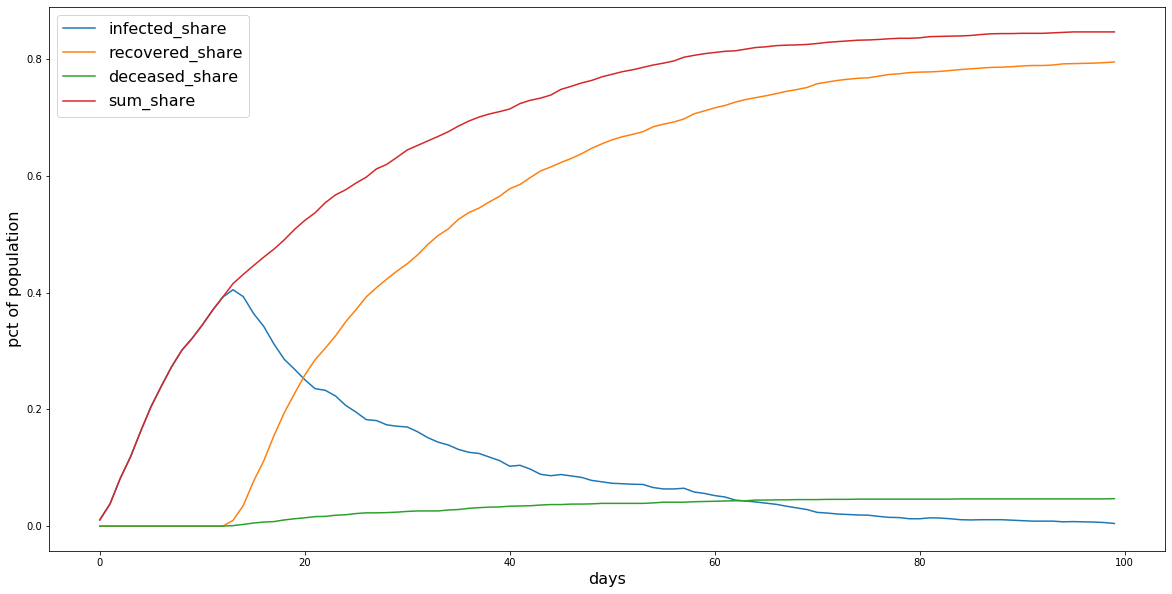

In [49]:
days = list(range(num_days))
infected_share = [n/total_people for n in people_infected]
recovered_share = [n/total_people for n in people_recovered]
deceased_share = [n/total_people for n in people_deceased]

sum_share = []
for (x, y, z) in zip(people_infected, people_recovered, people_deceased):
    sum_share.append((x+y+z)/total_people)

plt.figure(figsize=(20,10))
plt.plot(days, infected_share, label='infected_share')
plt.plot(days, recovered_share, label='recovered_share')
plt.plot(days, deceased_share, label='deceased_share')
plt.plot(days, sum_share, label="sum_share")
plt.xlabel('days', fontsize=16)
plt.ylabel('pct of population', fontsize=16)
plt.legend(fontsize=16)
plt.show()

## For debugging

In [44]:
houses_n = 10
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 3
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

num_days = 20

min_household = 3 
max_household = 5
leave_prob = 1
test_delay = 0
public_spread = 0.50
random_spread = 0.10
house_spread = 0.80
recovery_days = 14
recovery_prob = 0.95
app_penetration = 0.5
symptom_days = 4
symptom_prob = 1

ct_compliance_array = np.linspace(0.6, 0.9, num_days)
test_prob_array = np.linspace(0.2, 0.6, num_days)
leave_prob_array = np.linspace(0.8, 0.2, num_days)

houses_dict, total_people, people_infected, people_recovered, people_deceased = run_simulation(
    num_days=num_days, 
    houses_n=houses_n, 
    houses_x=houses_x, 
    houses_y=houses_y, 
    landmarks_n=landmarks_n, 
    landmarks_x=landmarks_x, 
    landmarks_y=landmarks_y, 
    min_household=min_household, 
    max_household=max_household,
    app_penetration=app_penetration,
    ct_compliance_array=ct_compliance_array,
    leave_prob_array=leave_prob_array,
    test_prob_array=test_prob_array,
    test_delay=test_delay,
    symptom_days = symptom_days,
    symptom_prob = symptom_prob,
    public_spread=public_spread, 
    random_spread=random_spread, 
    house_spread=house_spread,
    recovery_days=recovery_days,
    recovery_prob=recovery_prob,
    display_dicts=True)


houses_day0


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day1


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[1, 1, 1, 1]","[True, True, True, True]","[1, 1, 1, 1]",True,False,"[False, True, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[1, 1, 1, 1]","[True, True, True, True]","[1, 1, 1, 1]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day2


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, False]","[1, 1, 0]","[True, True, False]","[1, 1, 0]",True,False,"[True, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, True, False]","[0, 0, 1, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[2, 2, 2, 2]","[True, True, True, True]","[2, 2, 2, 2]",True,False,"[False, True, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, False, True]","[1, 1, 0, 1]","[True, True, False, True]","[1, 1, 0, 1]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[2, 2, 2, 2]","[True, True, True, True]","[2, 2, 2, 2]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[1, 1, 1]","[True, True, True]","[1, 1, 1]",True,False,"[False, False, True]","[False, False, False]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[True, False, False]","[1, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day3


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[2, 2, 1]","[True, True, True]","[2, 2, 1]",True,False,"[True, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, True, False]","[0, 0, 2, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[3, 3, 3, 3]","[True, True, True, True]","[3, 3, 3, 3]",True,False,"[False, True, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[2, 2, 1, 2]","[True, True, True, True]","[2, 2, 1, 2]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[3, 3, 3, 3]","[True, True, True, True]","[3, 3, 3, 3]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[2, 2, 2]","[True, True, True]","[2, 2, 2]",True,False,"[False, False, True]","[False, False, False]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[True, False, False]","[2, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day4


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[3, 3, 2]","[True, True, True]","[3, 3, 2]",True,False,"[True, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[1, 1, 1, 1]","[True, True, True, True]","[1, 1, 1, 1]",True,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[4, 4, 4, 4]","[True, True, True, True]","[4, 4, 4, 4]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[3, 3, 2, 3]","[True, True, True, True]","[3, 3, 2, 3]",True,False,"[True, False, False, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[4, 4, 4, 4]","[True, True, True, True]","[4, 4, 4, 4]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[3, 3, 3]","[True, True, True]","[3, 3, 3]",True,False,"[False, False, True]","[False, False, False]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[True, False, False]","[3, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day5


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[4, 4, 3]","[True, True, True]","[4, 4, 3]",True,False,"[True, True, False]","[True, True, False]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[2, 2, 2, 2]","[True, True, True, True]","[2, 2, 2, 2]",True,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[5, 5, 5, 5]","[True, True, True, True]","[5, 5, 5, 5]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, False]","[1, 1, 0]","[True, True, False]","[1, 1, 0]",True,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[4, 4, 3, 4]","[True, True, True, True]","[4, 4, 3, 4]",True,False,"[True, False, False, True]","[True, True, False, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[5, 5, 5, 5]","[True, True, True, True]","[5, 5, 5, 5]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[4, 4, 4]","[True, True, True]","[4, 4, 4]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[1, 1, 1]","[True, True, True]","[1, 1, 1]",True,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day6


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[5, 5, 4]","[True, True, True]","[5, 5, 4]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[3, 3, 3, 3]","[True, True, True, True]","[3, 3, 3, 3]",True,False,"[False, False, True, True]","[False, False, False, False]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[6, 6, 6, 6]","[True, True, True, True]","[6, 6, 6, 6]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[2, 2, 1]","[True, True, True]","[2, 2, 1]",True,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[5, 5, 4, 5]","[True, True, True, True]","[5, 5, 4, 5]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[6, 6, 6, 6]","[True, True, True, True]","[6, 6, 6, 6]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[5, 5, 5]","[True, True, True]","[5, 5, 5]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[2, 2, 2]","[True, True, True]","[2, 2, 2]",True,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day7


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[6, 6, 5]","[True, True, True]","[6, 6, 5]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[4, 4, 4, 4]","[True, True, True, True]","[4, 4, 4, 4]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[7, 7, 7, 7]","[True, True, True, True]","[7, 7, 7, 7]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[3, 3, 2]","[True, True, True]","[3, 3, 2]",True,False,"[False, True, False]","[False, False, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[6, 6, 5, 6]","[True, True, True, True]","[6, 6, 5, 6]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[7, 7, 7, 7]","[True, True, True, True]","[7, 7, 7, 7]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[6, 6, 6]","[True, True, True]","[6, 6, 6]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[3, 3, 3]","[True, True, True]","[3, 3, 3]",True,False,"[False, True, True]","[False, False, False]","[False, False, False]","[False, False, False]"



houses_day8


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[7, 7, 6]","[True, True, True]","[7, 7, 6]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[5, 5, 5, 5]","[True, True, True, True]","[5, 5, 5, 5]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[8, 8, 8, 8]","[True, True, True, True]","[8, 8, 8, 8]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[4, 4, 3]","[True, True, True]","[4, 4, 3]",True,False,"[False, True, False]","[True, True, False]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[7, 7, 6, 7]","[True, True, True, True]","[7, 7, 6, 7]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[8, 8, 8, 8]","[True, True, True, True]","[8, 8, 8, 8]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[7, 7, 7]","[True, True, True]","[7, 7, 7]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[4, 4, 4]","[True, True, True]","[4, 4, 4]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day9


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[8, 8, 7]","[True, True, True]","[8, 8, 7]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[6, 6, 6, 6]","[True, True, True, True]","[6, 6, 6, 6]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[9, 9, 9, 9]","[True, True, True, True]","[9, 9, 9, 9]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[5, 5, 4]","[True, True, True]","[5, 5, 4]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[8, 8, 7, 8]","[True, True, True, True]","[8, 8, 7, 8]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[9, 9, 9, 9]","[True, True, True, True]","[9, 9, 9, 9]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[8, 8, 8]","[True, True, True]","[8, 8, 8]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[5, 5, 5]","[True, True, True]","[5, 5, 5]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day10


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[9, 9, 8]","[True, True, True]","[9, 9, 8]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[7, 7, 7, 7]","[True, True, True, True]","[7, 7, 7, 7]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[10, 10, 10, 10]","[True, True, True, True]","[10, 10, 10, 10]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[6, 6, 5]","[True, True, True]","[6, 6, 5]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[9, 9, 8, 9]","[True, True, True, True]","[9, 9, 8, 9]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[10, 10, 10, 10]","[True, True, True, True]","[10, 10, 10, 10]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[9, 9, 9]","[True, True, True]","[9, 9, 9]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[6, 6, 6]","[True, True, True]","[6, 6, 6]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day11


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[10, 10, 9]","[True, True, True]","[10, 10, 9]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[8, 8, 8, 8]","[True, True, True, True]","[8, 8, 8, 8]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[11, 11, 11, 11]","[True, True, True, True]","[11, 11, 11, 11]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[7, 7, 6]","[True, True, True]","[7, 7, 6]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[10, 10, 9, 10]","[True, True, True, True]","[10, 10, 9, 10]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[11, 11, 11, 11]","[True, True, True, True]","[11, 11, 11, 11]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[10, 10, 10]","[True, True, True]","[10, 10, 10]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[7, 7, 7]","[True, True, True]","[7, 7, 7]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day12


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[11, 11, 10]","[True, True, True]","[11, 11, 10]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[9, 9, 9, 9]","[True, True, True, True]","[9, 9, 9, 9]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[12, 12, 12, 12]","[True, True, True, True]","[12, 12, 12, 12]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[8, 8, 7]","[True, True, True]","[8, 8, 7]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[11, 11, 10, 11]","[True, True, True, True]","[11, 11, 10, 11]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[12, 12, 12, 12]","[True, True, True, True]","[12, 12, 12, 12]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[11, 11, 11]","[True, True, True]","[11, 11, 11]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[8, 8, 8]","[True, True, True]","[8, 8, 8]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day13


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[12, 12, 11]","[True, True, True]","[12, 12, 11]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[10, 10, 10, 10]","[True, True, True, True]","[10, 10, 10, 10]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[True, True, True, True]","[13, 13, 13, 13]","[True, True, True, True]","[13, 13, 13, 13]",False,True,"[False, True, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[9, 9, 8]","[True, True, True]","[9, 9, 8]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[12, 12, 11, 12]","[True, True, True, True]","[12, 12, 11, 12]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[True, True, True, True]","[13, 13, 13, 13]","[True, True, True, True]","[13, 13, 13, 13]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[12, 12, 12]","[True, True, True]","[12, 12, 12]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[9, 9, 9]","[True, True, True]","[9, 9, 9]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day14


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[True, True, True]","[13, 13, 12]","[True, True, True]","[13, 13, 12]",False,True,"[True, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[11, 11, 11, 11]","[True, True, True, True]","[11, 11, 11, 11]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[10, 10, 9]","[True, True, True]","[10, 10, 9]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[True, True, True, True]","[13, 13, 12, 13]","[True, True, True, True]","[13, 13, 12, 13]",False,True,"[True, False, False, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[True, True, True]","[13, 13, 13]","[True, True, True]","[13, 13, 13]",False,True,"[False, False, True]","[True, True, True]","[False, False, False]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[10, 10, 10]","[True, True, True]","[10, 10, 10]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day15


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, True]","[0, 0, 13]","[False, False, True]","[0, 0, 13]",False,True,"[True, True, False]","[False, False, True]","[False, True, False]","[True, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[12, 12, 12, 12]","[True, True, True, True]","[12, 12, 12, 12]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[11, 11, 10]","[True, True, True]","[11, 11, 10]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, True, False]","[0, 0, 13, 0]","[False, False, True, False]","[0, 0, 13, 0]",False,True,"[True, False, False, True]","[False, False, True, False]","[True, True, False, True]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[True, True, True]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[11, 11, 11]","[True, True, True]","[11, 11, 11]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day16


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, True, True]","[True, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[True, True, True, True]","[13, 13, 13, 13]","[True, True, True, True]","[13, 13, 13, 13]",False,True,"[False, False, True, True]","[True, True, True, True]","[False, False, False, False]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[12, 12, 11]","[True, True, True]","[12, 12, 11]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[True, True, True]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[12, 12, 12]","[True, True, True]","[12, 12, 12]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day17


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, True, True]","[True, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[True, True, True]","[13, 13, 12]","[True, True, True]","[13, 13, 12]",False,True,"[False, True, False]","[True, True, True]","[False, False, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[True, True, True]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[True, True, True]","[13, 13, 13]","[True, True, True]","[13, 13, 13]",False,True,"[False, True, True]","[True, True, True]","[False, False, False]","[False, False, False]"



houses_day18


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, True, True]","[True, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, True]","[0, 0, 13]","[False, False, True]","[0, 0, 13]",False,True,"[False, True, False]","[False, False, True]","[True, True, False]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[True, True, True]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[True, True, True]","[False, False, False]"



houses_day19


,coordinates,num_people,infected,infected_days,exposed,exposed_days,non-symptomatic_infection_present,symptomatic_infection_present,has_app,symptomatic,recovered,deceased
0,"(191.66206235512416, 183.09845975522697)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[True, True, False]","[False, False, False]","[False, True, True]","[True, False, False]"
1,"(764.022254385831, 87.75452620697763)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, False, True, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
2,"(855.254992018645, 205.53248409937464)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[False, True, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
3,"(911.511337288566, 318.2283200543325)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, False]","[False, False, False]","[True, True, True]","[False, False, False]"
4,"(977.0945284173024, 970.5907478545977)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, True, True]","[False, False, False, False]"
5,"(536.5392955440948, 844.097676621105)",4,"[False, False, False, False]","[0, 0, 0, 0]","[False, False, False, False]","[0, 0, 0, 0]",False,False,"[True, False, False, True]","[False, False, False, False]","[True, True, False, True]","[False, False, True, False]"
6,"(80.4892693311553, 223.0668020856271)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, False, True]","[False, False, False]","[True, True, True]","[False, False, False]"
7,"(148.12586479872817, 375.18421083965666)",3,"[False, False, False]","[0, 0, 0]","[False, False, False]","[0, 0, 0]",False,False,"[False, True, True]","[False, False, False]","[True, True, True]","[False, False, False]"
